In [1]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody

In [2]:
mesh, softbody = data.get_xpbd_grape()

torch.Size([600, 3])
torch.Size([1200, 3])


In [3]:
# control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
#                                [0.00023, 0.015, 0.002],
#                                [0.000314, 0.03, 0.003],
#                                [0.000154, 0.02, 0.004],
#                                [0.00024, 0.01, 0.005]])
control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
                               [0.000186, 0.008863, 0.002481],
                               [0.000208, 0.00664, 0.003521],
                               [0.000197, 0.004594, 0.004361],
                               [0.000208, 0.002349, 0.005903],
                               [0.000197, -0.00004, 0.006602],
                               [0.000208, -0.00204, 0.007502],
                               [0.000208, -0.00404, 0.008502]])

In [4]:
control_point = 31

In [5]:
target_point = 26

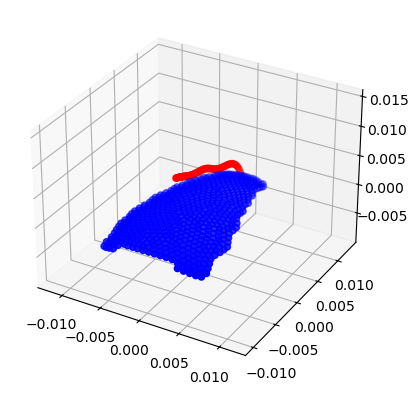

In [6]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
utils.axisEqual3D(ax)
plt.show()

In [7]:
control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)
softbody.fix_point(0, control_point)

cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

In [8]:
def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    # V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0
    V_boundary_stiffness_threshold = V_boundary_stiffness_threshold * torch.sigmoid(V_boundary_stiffness_threshold - 1e-3)


    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)

In [9]:
pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')

# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')

Actor (0x7fe68ec3a740)
  Center:                     (-9.851530194282532e-06, 0.0014494163915514946, -0.0009795548299327494)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -6.636E-03, 6.616E-03
  Y Bounds                    -1.040E-02, 1.330E-02
  Z Bounds                    -3.189E-03, 1.230E-03
  User matrix:                Set
  Has mapper:                 True

Property (0x7fe68ec3ab60)
  Ambient:                     0.0
  Ambient color:               Color(hex='#c0ab5eff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(hex='#c0ab5eff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(hex='#c0ab5eff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
 

In [10]:
with torch.no_grad():
    for t in range(1, control_trajectory.shape[0]):
        softbody.V[control_point] = control_trajectory[t]

        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()

        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        
        V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))

        mesh.points = softbody.V.cpu().numpy()
        # pl.show(interactive_update=True)

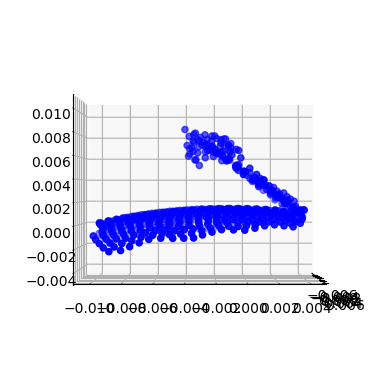

In [11]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
plt.show()

In [12]:
target_pos = softbody.V[control_point].clone()

In [13]:
target_pos

tensor([ 0.0002, -0.0040,  0.0085], device='cuda:0')

In [67]:
mesh, softbody = data.get_xpbd_grape()
softbody.fix_point(0, control_point)

torch.Size([600, 3])
torch.Size([1200, 3])


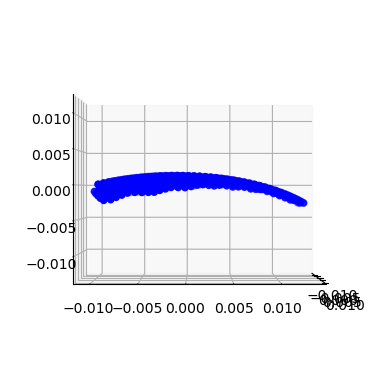

In [68]:
# interpolate trajectory
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
# ax.scatter(mesh.points[control_list, 0], mesh.points[control_list, 1], mesh.points[control_list, 2], c='r', marker='o')
# ax.scatter(mesh.points[target_list, 0], mesh.points[target_list, 1], mesh.points[target_list, 2], c='y', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)

In [69]:
# Hardcoded control trajectory
cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

In [70]:
def loss_fn(target, predict):
    return torch.norm(target - predict)

In [71]:
# init

for t in range(1, 20):
    softbody.V[control_point] = control_trajectory[t]

    step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=None,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=cfg.use_shape_matching,
                    use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()

    energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
    
    V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))

    mesh.points = softbody.V.cpu().numpy()
    # pl.show(interactive_update=True)

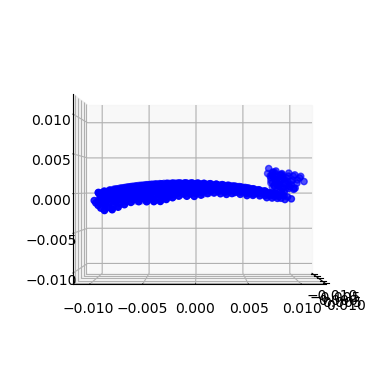

In [72]:
# interpolate trajectory
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
# ax.scatter(mesh.points[control_list, 0], mesh.points[control_list, 1], mesh.points[control_list, 2], c='r', marker='o')
# ax.scatter(mesh.points[target_list, 0], mesh.points[target_list, 1], mesh.points[target_list, 2], c='y', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)

In [73]:
softbody.V.requires_grad_(True)
softbody.V_velocity.requires_grad_(True)
# softbody.grasp_point.requires_grad_(True)

tensor([[-8.7311e-06,  1.7884e-05, -5.4017e-06],
        [-8.0443e-06,  1.4962e-05, -3.1781e-06],
        [-4.1677e-06,  1.5053e-05, -3.1549e-06],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0',
       requires_grad=True)

In [74]:
torch.autograd.set_detect_anomaly(True)

In [75]:
control = []
loss_list = []
for t in range(1000):
    print(t)
    step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=None,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=cfg.use_shape_matching,
                    use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)

    ref_V_boundary_stiffness = V_boundary_stiffness[:cfg.n_surf].detach().clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    # print(torch.sigmoid(1e9 * (1e-8 - energy)))
    # V_boundary_stiffness[:cfg.n_surf][energy.squeeze() > 1e-8] = 1e-5
    V_boundary_stiffness[:cfg.n_surf] = ref_V_boundary_stiffness * torch.sigmoid(1e9 * (1e-8 - energy))

    loss = loss_fn(target_pos, V_ref[target_point])
    loss.backward()

    if loss > 5e-4:
        with torch.no_grad():
            V_ref[control_point] -= 0.002 * softbody.V.grad[control_point]
    else:
        control.append(V_ref[control_point].detach().cpu().numpy())
        softbody.V = V_ref.detach().clone().requires_grad_(True)
        softbody.V_velocity = V_velocity_ref.detach().clone().requires_grad_(True)
        break
    control.append(V_ref[control_point].detach().cpu().numpy())
    print('loss:', loss)
    loss_list.append(loss.detach().cpu().numpy())
    # print(softbody.V.grad[softbody.control_list])
    print(softbody.V.grad[control_point])
    softbody.V = V_ref.detach().clone().requires_grad_(True)
    softbody.V_velocity = V_velocity_ref.detach().clone().requires_grad_(True)

    
    # mesh.points = softbody.V.cpu().numpy()

0
loss: tensor(0.0148, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([ 0.0197,  0.0266, -0.1915], device='cuda:0')
1
loss: tensor(0.0148, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0021, 0.0261, 0.0609], device='cuda:0')
2
loss: tensor(0.0148, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0009, 0.0226, 0.0859], device='cuda:0')
3
loss: tensor(0.0148, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0033, 0.0218, 0.0237], device='cuda:0')
4
loss: tensor(0.0148, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0017, 0.0221, 0.0239], device='cuda:0')
5
loss: tensor(0.0148, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0013, 0.0217, 0.0237], device='cuda:0')
6
loss: tensor(0.0148, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0006, 0.0216, 0.0225], device='cuda:0')
7
loss: tensor(0.0148, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0002, 0.0208, 0.0261]

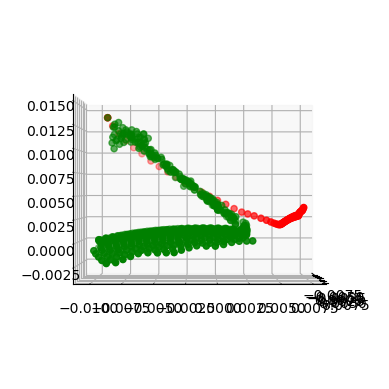

In [76]:
# interpolate trajectory
control = np.array(control)
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='g', marker='o')
ax.scatter(control[:, 0], control[:, 1], control[:, 2], c='r', marker='o')
# ax.scatter(mesh.points[target_list, 0], mesh.points[target_list, 1], mesh.points[target_list, 2], c='b', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
plt.show()

Text(0, 0.5, 'loss')

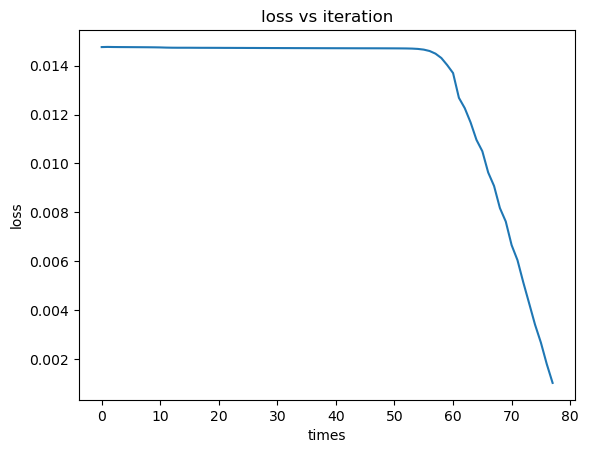

In [77]:
plt.plot(loss_list)
plt.title('loss vs iteration')
plt.xlabel('times')
plt.ylabel('loss')

In [78]:
softbody.V[target_point]

tensor([ 8.8795e-05, -4.2134e-03,  8.3523e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [79]:
target_pos

tensor([ 0.0002, -0.0040,  0.0085], device='cuda:0')